# Tutorial 5: Flow Matching - From SDEs to ODEs

## Learning Objectives

By the end of this tutorial, you will:
- **Understand** the fundamental difference between SDE (DDPM) and ODE (Flow Matching) formulations
- **Implement** conditional flow matching from scratch with probability paths and velocity fields
- **Visualize** how data flows through probability space over time
- **Compare** different ODE solvers (Euler vs RK45) and their trade-offs
- **Analyze** when to use flow matching versus diffusion models

## Key Conceptual Difference

**DDPM (Tutorial 4)**: Stochastic Differential Equation
$$dx = f(x,t)dt + g(t)dW \quad \text{[SDE with noise term]}$$
- Stochastic (random) sampling process
- Requires noise injection at each step
- More robust but slower

**Flow Matching (This Tutorial)**: Ordinary Differential Equation
$$\frac{dx}{dt} = v_\theta(x,t) \quad \text{[ODE, deterministic]}$$
- Deterministic path from noise to data
- No noise needed during sampling
- Can use sophisticated ODE solvers

## Tutorial Structure

This tutorial includes **TODOs** that you'll complete based on lecture material. You'll learn by implementing, not just running!

**Expected time**: ~60-90 minutes

---
## Setup and Imports

First, let's import all necessary libraries.

In [1]:
# Standard libraries
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm
import os

# Tutorial modules
from flow_matching_tutorial.models import SimpleMLPDenoiser
from flow_matching_tutorial.flow import ConditionalFlowMatching, check_implementation
from flow_matching_tutorial.utils import (
    create_toy_dataset,
    ToyDataLoader,
    set_seed,
    count_parameters,
    get_device,
)
from flow_matching_tutorial.visualization import (
    visualize_probability_paths,
    visualize_velocity_field,
    visualize_samples,
    plot_training_curves,
    visualize_reverse_process_trajectory,
    create_reverse_process_animation,
    visualize_marginal_distributions,
    compare_ode_solvers,
)

# Set plotting style
plt.style.use('default')
%matplotlib inline

print("All imports successful!")

All imports successful!


---
## Step 0: Check Your Implementation

Before we begin, let's verify that you've completed the required TODOs in `flow.py`.

### What You Need to Implement:

1. **TODO #1: Probability Paths** - How to interpolate between noise $x_0$ and data $x_1$
   - Linear path: $x_t = (1-t) x_0 + t x_1$
   - Variance preserving: $x_t = \cos(\frac{\pi t}{2}) x_0 + \sin(\frac{\pi t}{2}) x_1$

2. **TODO #2: Velocity Field** - The time derivative of the path
   - Linear: $u_t = x_1 - x_0$ (constant)
   - Variance preserving: $u_t = -\frac{\pi}{2}\sin(\frac{\pi t}{2})x_0 + \frac{\pi}{2}\cos(\frac{\pi t}{2})x_1$ (time-varying)

3. **TODO #3: Flow Matching Loss** - The training objective
   $$\mathcal{L} = \mathbb{E}_{t, x_0, x_1} \left[\|v_\theta(x_t, t) - u_t\|^2\right]$$

If you haven't completed these yet, open `flow_matching_tutorial/flow.py` and implement them based on your lecture notes!

In [2]:
# Check if TODOs are implemented
if not check_implementation():
    print("\nPlease complete the TODOs in flow.py before proceeding!")
    print("Refer to your lecture notes and the comments in the code.")
else:
    print("\nGreat! All TODOs completed. Let's continue!")

Checking implementation...

ATTENTION: You have TODOs to complete!
  - TODO #1: sample_probability_path()
  - TODO #2: compute_target_velocity()
  - TODO #3: training_loss()

Please implement these functions based on your lecture notes.
Then run the tutorial again!

Please complete the TODOs in flow.py before proceeding!
Refer to your lecture notes and the comments in the code.


---
## Step 1: Configuration

Let's set up our experiment parameters.

### Key Parameters:
- **dataset_type**: Which 2D distribution to model ("moons", "circles", "swiss_roll", "two_gaussians")
- **path_type**: Probability path to use ("linear" or "variance_preserving")
- **n_epochs**: Number of training iterations
- **n_euler_steps**: Number of discretization steps for Euler ODE solver

In [3]:
# Set random seed for reproducibility
set_seed(42)

# Get device
device = get_device()
print(f"Using device: {device}")

# Create output directory
os.makedirs("outputs", exist_ok=True)

# Configuration
config = {
    # Data
    "dataset_type": "moons",  # Try: "moons", "circles", "swiss_roll", "two_gaussians"
    "n_samples": 10000,
    "noise": 0.05,
    
    # Flow Matching - KEY CHOICE!
    "path_type": "variance_preserving",  # Try: "linear", "variance_preserving"
    
    # Model Architecture
    "hidden_dim": 128,
    "time_embed_dim": 32,
    "n_layers": 3,
    
    # Training
    "batch_size": 256,
    "n_epochs": 100,
    "learning_rate": 1e-3,
    
    # Sampling
    "n_samples_to_generate": 1000,
    "n_euler_steps": 100,
    
    # Visualization
    "forward_timesteps": [0.0, 0.25, 0.5, 0.75, 1.0],  # Which timesteps to visualize
    "n_reverse_plots": 6,  # Number of reverse process plots
}

print("\nConfiguration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Using device: cpu

Configuration:
  dataset_type: moons
  n_samples: 10000
  noise: 0.05
  path_type: variance_preserving
  hidden_dim: 128
  time_embed_dim: 32
  n_layers: 3
  batch_size: 256
  n_epochs: 100
  learning_rate: 0.001
  n_samples_to_generate: 1000
  n_euler_steps: 100
  forward_timesteps: [0.0, 0.25, 0.5, 0.75, 1.0]
  n_reverse_plots: 6


---
## Step 2: Create Dataset

We'll use the same 2D toy datasets as Tutorial 1 for fair comparison.

### Mathematical Setup:

Our goal is to learn a transformation:
$$p_0(x) \xrightarrow{\text{flow}} p_1(x)$$

Where:
- $p_0(x) = \mathcal{N}(0, I)$ is Gaussian noise (easy to sample)
- $p_1(x)$ is the complex data distribution (what we want to generate)

### Why 2D Toy Data?
- **Visualizable**: We can plot the entire distribution
- **Fast**: Quick training for experimentation
- **Pedagogical**: Easier to understand what the model is learning

The same principles extend to high-dimensional data (images, audio, etc.)!

Created 'moons' dataset
  Shape: torch.Size([10000, 2])
  Mean: [-0.000, -0.000]
  Std:  [1.500, 1.500]


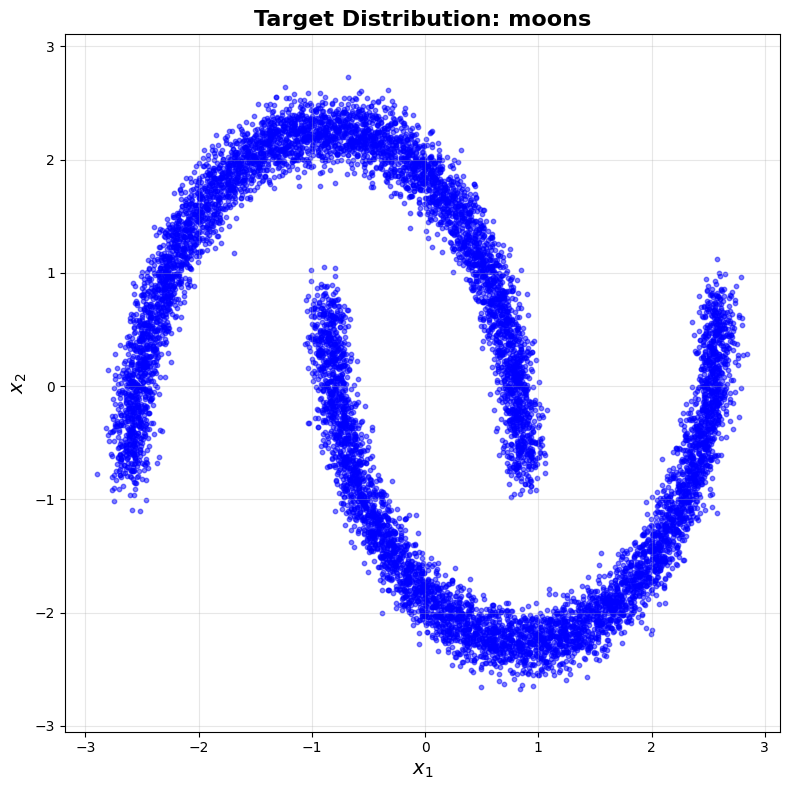


Data loader created with batch size 256


In [4]:
# Create dataset
data = create_toy_dataset(
    dataset_type=config["dataset_type"],
    n_samples=config["n_samples"],
    noise=config["noise"],
)

print(f"Created '{config['dataset_type']}' dataset")
print(f"  Shape: {data.shape}")
print(f"  Mean: [{data.mean(0)[0]:.3f}, {data.mean(0)[1]:.3f}]")
print(f"  Std:  [{data.std(0)[0]:.3f}, {data.std(0)[1]:.3f}]")

# Visualize the target distribution
plt.figure(figsize=(8, 8))
data_np = data.cpu().numpy() if torch.is_tensor(data) else data
plt.scatter(data_np[:, 0], data_np[:, 1], alpha=0.5, s=10, c='blue')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.title(f'Target Distribution: {config["dataset_type"]}', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Create data loader
data_loader = ToyDataLoader(
    data, batch_size=config["batch_size"], shuffle=True
)

print(f"\nData loader created with batch size {config['batch_size']}")

### Reflection Questions:

1. **Why do we use toy 2D datasets instead of real images for learning?**
   <details>
   <summary>Click for answer</summary>
   Because we can visualize the entire probability distribution in 2D, making it easier to understand what the model is learning. The same principles apply to high-dimensional data!
   </details>

2. **What distribution will we start from when generating samples?**
   <details>
   <summary>Click for answer</summary>
   We'll start from Gaussian noise $\mathcal{N}(0, I)$ and flow it to the data distribution.
   </details>

---
## Step 3: Initialize Flow Matching

Now let's create our Conditional Flow Matching instance.

### Mathematical Framework:

Flow matching learns a **probability path** $p_t(x)$ that interpolates between:
- $p_0(x) = \mathcal{N}(0, I)$ (noise)
- $p_1(x) = p_{\text{data}}(x)$ (data)

The path is governed by a **velocity field** $v_\theta(x, t)$:
$$\frac{dx}{dt} = v_\theta(x, t)$$

### Two Probability Paths:

**1. Linear Path** (simple straight-line interpolation):
$$x_t = (1-t)x_0 + tx_1$$
- Constant velocity: $u_t = x_1 - x_0$
- Fast to compute
- Norm decreases in the middle

**2. Variance Preserving** (geodesic on sphere):
$$x_t = \cos\left(\frac{\pi t}{2}\right)x_0 + \sin\left(\frac{\pi t}{2}\right)x_1$$
- Time-varying velocity: $u_t = -\frac{\pi}{2}\sin\left(\frac{\pi t}{2}\right)x_0 + \frac{\pi}{2}\cos\left(\frac{\pi t}{2}\right)x_1$
- Preserves norm (when $\|x_0\| = \|x_1\|$)
- Often better sample quality

### Key Difference from DDPM:
- **DDPM**: Uses a fixed noise schedule $\beta_t$, adds noise stochastically
- **Flow Matching**: Designs a probability path, deterministic ODE

In [5]:
# Initialize flow matching
flow = ConditionalFlowMatching(
    path_type=config["path_type"],
    device=device,
)

print(f"Created Conditional Flow Matching")
print(f"  Probability path: {config['path_type']}")
print(f"  Process type: ODE (deterministic)")
print(f"\nCompare with Tutorial 1:")
print(f"  DDPM: SDE (stochastic) - dx = f(x,t)dt + g(t)dW")
print(f"  Flow: ODE (deterministic) - dx/dt = v(x,t)")

Created Conditional Flow Matching
  Probability path: variance_preserving
  Process type: ODE (deterministic)

Compare with Tutorial 1:
  DDPM: SDE (stochastic) - dx = f(x,t)dt + g(t)dW
  Flow: ODE (deterministic) - dx/dt = v(x,t)


### Visualize Probability Paths

Let's see how the two probability paths differ visually!

**What to look for:**
- Linear path: Straight line (chord)
- Variance Preserving: Curved arc (geodesic)
- Arrow lengths show velocity magnitude

NotImplementedError: TODO: Implement linear probability path!
Formula: x_t = (1-t) * x_0 + t * x_1 + sigma_t * epsilon
This is a warm-up - implement the simple version first.

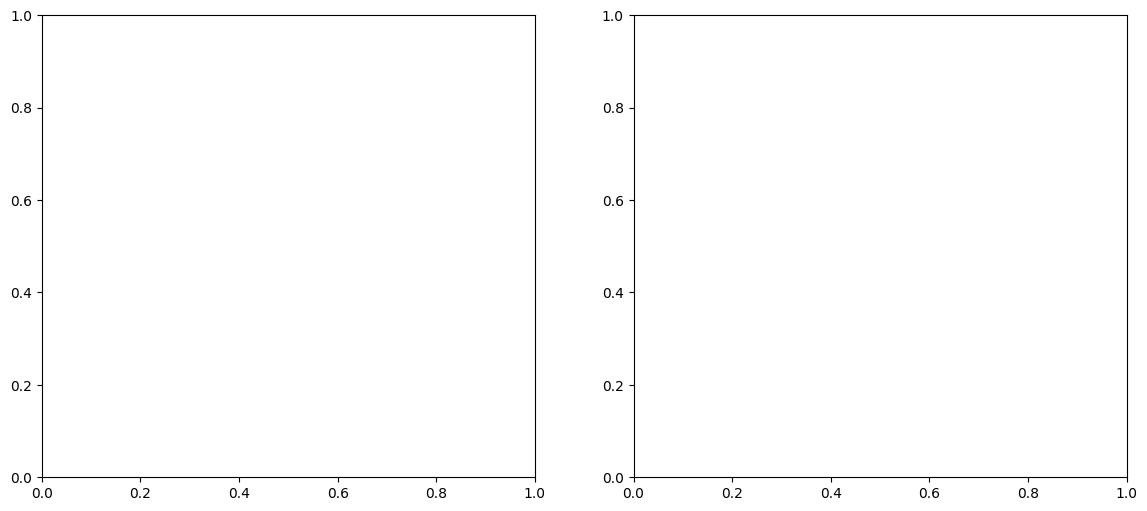

In [6]:
# Visualize both probability paths
visualize_probability_paths(flow, save_path="outputs/probability_paths.png")

### Visualize Forward Flow Process

Let's see how the flow process transforms our data at different timesteps!

**Forward Flow Process:**
$$x_0 \sim p_{\text{data}}(x) \xrightarrow{t \in [0,1]} x_t \sim p_t(x) \xrightarrow{t=1} x_1 \sim \mathcal{N}(0,I)$$

We'll visualize the data distribution at timesteps: $t \in \{0, 0.25, 0.5, 0.75, 1.0\}$

**What to observe:**
- At $t=0$: Original data structure
- At $t=0.5$: Partially "flowed" toward noise
- At $t=1$: Should look like Gaussian noise

In [ ]:
def visualize_forward_flow_process(
    flow,
    data,
    timesteps,
    n_samples=500,
    save_path=None
):
    """
    Visualize how data flows toward noise at different timesteps.
    
    This shows the forward process: data → noise
    (The reverse process during sampling goes: noise → data)
    """
    n_steps = len(timesteps)
    fig, axes = plt.subplots(1, n_steps, figsize=(5 * n_steps, 5))
    
    if n_steps == 1:
        axes = [axes]
    
    # Sample subset of data - handle both Tensor and numpy array
    if torch.is_tensor(data):
        x_1 = data[:n_samples].float().to(flow.device)
    else:
        x_1 = torch.from_numpy(data[:n_samples]).float().to(flow.device)
    
    for idx, (ax, t) in enumerate(zip(axes, timesteps)):
        # Sample x_0 ~ N(0,I) (noise)
        x_0 = torch.randn_like(x_1, device=flow.device)
        
        # Compute x_t along the probability path
        t_tensor = torch.full((n_samples,), t, device=flow.device)
        x_t = flow.sample_probability_path(x_0, x_1, t_tensor)
        
        # Convert to numpy for plotting
        x_t_np = x_t.cpu().numpy()
        
        # Plot
        ax.scatter(x_t_np[:, 0], x_t_np[:, 1], alpha=0.6, s=15, c='blue')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_aspect('equal')
        ax.set_title(f't = {t:.2f}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.set_ylabel('$x_2$', fontsize=12)
        ax.set_xlabel('$x_1$', fontsize=12)
        
        # Add annotation
        if t == 0.0:
            ax.text(0.5, 0.95, 'Data', transform=ax.transAxes,
                   fontsize=11, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
        elif t == 1.0:
            ax.text(0.5, 0.95, 'Noise', transform=ax.transAxes,
                   fontsize=11, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
        else:
            ax.text(0.5, 0.95, 'Flowing...', transform=ax.transAxes,
                   fontsize=11, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    plt.suptitle(f'Forward Flow Process: Data → Noise ({config["path_type"]} path)', 
                 fontsize=16, y=1.02, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved forward flow visualization to {save_path}")
    
    plt.show()

# Visualize forward flow process
print("\nVisualizing Forward Flow Process...")
print(f"Timesteps: {config['forward_timesteps']}")
visualize_forward_flow_process(
    flow,
    data,
    timesteps=config['forward_timesteps'],
    save_path="outputs/forward_flow_process.png"
)

### Reflection Questions:

1. **What happens to the data structure as $t$ increases from 0 to 1?**
   <details>
   <summary>Click for answer</summary>
   The structured data distribution gradually transforms into unstructured Gaussian noise. At t=0 we see the original pattern, and by t=1 it looks like random noise.
   </details>

2. **Why does the linear path's distribution "shrink" toward the origin at t=0.5?**
   <details>
   <summary>Click for answer</summary>
   Linear interpolation averages the positions, so $x_t = 0.5x_0 + 0.5x_1$. When averaging vectors that point in different directions, the result has smaller magnitude (norm decreases).
   </details>

3. **How does variance preserving path differ visually at t=0.5?**
   <details>
   <summary>Click for answer</summary>
   The variance preserving path maintains the "spread" better because it preserves the norm. The distribution doesn't shrink as much toward the origin.
   </details>

---
## Step 4: Create Model

We use the **same architecture** as Tutorial 1!

### Neural Network Architecture:

The model $v_\theta(x, t)$ predicts the velocity field:
$$v_\theta: \mathbb{R}^d \times [0,1] \rightarrow \mathbb{R}^d$$

**Input:**
- Position $x \in \mathbb{R}^2$ (current location in probability space)
- Time $t \in [0,1]$ (where we are along the path)

**Output:**
- Velocity $v \in \mathbb{R}^2$ (which direction to flow)

### Key Insight:
The only difference between DDPM and Flow Matching models:
- **DDPM**: Model predicts **noise** $\epsilon_\theta(x, t)$
- **Flow**: Model predicts **velocity** $v_\theta(x, t)$

The architecture is identical - only the interpretation changes!

In [ ]:
# Create model
model = SimpleMLPDenoiser(
    input_dim=2,
    hidden_dim=config["hidden_dim"],
    time_embed_dim=config["time_embed_dim"],
    n_layers=config["n_layers"],
).to(device)

n_params = count_parameters(model)
print(f"Created SimpleMLPDenoiser")
print(f"  Architecture: 2D → {config['hidden_dim']} (×{config['n_layers']}) → 2D")
print(f"  Time embedding: {config['time_embed_dim']} dimensions")
print(f"  Total parameters: {n_params:,}")
print(f"\nNote: Same architecture as DDPM!")
print(f"  DDPM output: Noise ε")
print(f"  Flow output: Velocity v")

### Reflection Questions:

1. **Why can we use the same model architecture for both DDPM and Flow Matching?**
   <details>
   <summary>Click for answer</summary>
   Both tasks are fundamentally the same: given (x, t), predict a vector in the same space as x. Only the training target differs (noise vs velocity).
   </details>

2. **What does the time embedding do?**
   <details>
   <summary>Click for answer</summary>
   It allows the model to condition its predictions on the current timestep t, so it can learn different behaviors at different times along the path.
   </details>

---
## Step 5: Train the Model

Now we train the model to predict the velocity field!

### Training Objective (Flow Matching Loss):

$$\mathcal{L} = \mathbb{E}_{t \sim \mathcal{U}(0,1), x_0 \sim \mathcal{N}(0,I), x_1 \sim p_{\text{data}}} \left[\|v_\theta(x_t, t) - u_t(x_t | x_0, x_1)\|^2\right]$$

**Breaking it down:**
1. Sample random time $t \sim \mathcal{U}(0,1)$
2. Sample noise $x_0 \sim \mathcal{N}(0,I)$
3. Sample data $x_1 \sim p_{\text{data}}$
4. Compute point on path: $x_t = \text{path}(x_0, x_1, t)$
5. Compute target velocity: $u_t = \frac{d}{dt}\text{path}(x_0, x_1, t)$
6. Predict velocity: $v_\theta(x_t, t)$
7. Minimize MSE: $\|v_\theta - u_t\|^2$

### Comparison with DDPM:

| Aspect | DDPM | Flow Matching |
|--------|------|---------------|
| **Loss** | $\mathbb{E}[\|\epsilon - \epsilon_\theta\|^2]$ | $\mathbb{E}[\|v - v_\theta\|^2]$ |
| **Target** | Noise $\epsilon$ | Velocity $v$ |
| **Sampling** | $t: T \rightarrow 0$ (reverse) | $t: 0 \rightarrow 1$ (forward) |
| **Process** | Stochastic | Deterministic |

Both are supervised regression - just different targets!

In [ ]:
# Setup optimizer
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

print(f"Training Objective: Flow Matching Loss")
print(f"   Target: Predict velocity v(x,t) at each point along the path")
print(f"   Loss: MSE between predicted and true velocity")
print(f"\nOptimizer: Adam with lr={config['learning_rate']}")
print(f"Training for {config['n_epochs']} epochs...\n")

In [ ]:
# Training loop
losses = []
model.train()

for epoch in range(config['n_epochs']):
    epoch_losses = []
    
    # Progress bar for batches
    pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{config['n_epochs']}")
    
    for batch in pbar:
        batch = batch.to(device)
        
        # Compute flow matching loss (uses your TODO #3 implementation)
        loss = flow.training_loss(model, batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record loss
        epoch_losses.append(loss.item())
        
        # Update progress bar
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    # Average loss for epoch
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_loss)
    
    # Print epoch summary every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{config['n_epochs']}, Loss: {avg_loss:.4f}")

print(f"\nTraining complete! Final loss: {losses[-1]:.4f}")

### Training Curve Analysis

In [ ]:
# Plot training curve
plot_training_curves(losses, save_path="outputs/training_curve.png")

print(f"\nTraining Statistics:")
print(f"   Initial loss: {losses[0]:.4f}")
print(f"   Final loss: {losses[-1]:.4f}")
print(f"   Reduction: {(1 - losses[-1]/losses[0])*100:.1f}%")

### Visualize Learned Velocity Field

Now let's see what velocity field the model learned!

**The velocity field** $v_\theta(x, t)$ tells us:
- **Direction**: Which way to flow from position $x$
- **Magnitude**: How fast to flow

We'll visualize it at $t=0.5$ (midpoint of the path).

In [ ]:
# Visualize velocity field at t=0.5
print("Visualizing learned velocity field at t=0.5...")
visualize_velocity_field(model, flow, t_value=0.5, save_path="outputs/velocity_field.png")

### Reflection Questions:

1. **What does the velocity field show?**
   <details>
   <summary>Click for answer</summary>
   The arrows show the direction and speed of flow at each point in space. They point from noise (at t=1) toward data (at t=0) when we reverse the flow.
   </details>

2. **Why does the training loss decrease over time?**
   <details>
   <summary>Click for answer</summary>
   The model is learning to better predict the target velocity at each point along the probability path. Lower loss = better velocity predictions.
   </details>

3. **How would you verify the model has learned the correct velocity field?**
   <details>
   <summary>Click for answer</summary>
   By generating samples! If the learned velocity field is correct, following it from noise should produce samples that look like the training data.
   </details>

---
## Step 6: Generate Samples

Time to generate new samples by solving the ODE!

### The Sampling Process:

We solve the **reverse ODE** from $t=0$ to $t=1$:
$$\frac{dx}{dt} = v_\theta(x, t), \quad x(0) \sim \mathcal{N}(0,I)$$

**Two ODE Solvers:**

**1. Euler Method** (simple, fixed step size):
$$x_{t+\Delta t} = x_t + v_\theta(x_t, t) \cdot \Delta t$$
- Simple to implement
- Fast but less accurate
- Requires many small steps

**2. RK45 (Runge-Kutta)** (sophisticated, adaptive):
- Automatically adjusts step size
- More accurate with fewer evaluations
- Recommended for production

### Key Difference from DDPM:
- **DDPM**: Iterative stochastic denoising (many steps, adds noise)
- **Flow**: Solve ODE deterministically (can use adaptive solvers)

In [ ]:
import time

model.eval()

print("Generating Samples using ODE Integration...\n")

# Method 1: Euler solver
print(f"Method 1: Euler solver ({config['n_euler_steps']} steps)")
start_time = time.time()

trajectory_euler = flow.sample(
    model,
    shape=(config["n_samples_to_generate"], 2),
    method="euler",
    n_steps=config["n_euler_steps"],
    return_trajectory=True,
)

euler_time = time.time() - start_time
samples_euler = torch.from_numpy(trajectory_euler[-1])
print(f"  Sampling time: {euler_time:.2f}s")
print(f"  NFE (function evaluations): {config['n_euler_steps']}")
print(f"  Generated {len(samples_euler)} samples")

# Method 2: RK45 solver
print(f"\nMethod 2: RK45 solver (adaptive steps)")
start_time = time.time()

samples_rk45 = flow.sample(
    model,
    shape=(config["n_samples_to_generate"], 2),
    method="rk45",
    return_trajectory=False,
)

rk45_time = time.time() - start_time
print(f"  Sampling time: {rk45_time:.2f}s")
print(f"  NFE: Adaptive (typically 20-50 evaluations)")
print(f"  Generated {len(samples_rk45)} samples")

print(f"\nSpeed comparison: {euler_time / rk45_time:.2f}x (Euler/RK45)")

### Visualize Reverse Process Step-by-Step

Let's see how samples evolve from noise to data!

**Reverse Process**: $\mathcal{N}(0,I) \xrightarrow{\text{ODE}} p_{\text{data}}$

We'll show the distribution at multiple timesteps as we integrate the ODE.

In [ ]:
def visualize_reverse_process_steps(
    trajectory,
    n_plots=6,
    save_path=None
):
    """
    Visualize the reverse process (noise → data) at multiple timesteps.
    """
    n_steps = len(trajectory)
    
    # Select evenly spaced frames
    indices = np.linspace(0, n_steps-1, n_plots, dtype=int)
    
    # Create grid of plots
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = axes.flatten() if n_plots > 1 else [axes]
    
    for idx, (ax, step_idx) in enumerate(zip(axes[:n_plots], indices)):
        samples = trajectory[step_idx]
        t_value = step_idx / (n_steps - 1)
        
        # Plot samples
        ax.scatter(samples[:, 0], samples[:, 1], alpha=0.6, s=15, c='blue')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_aspect('equal')
        ax.set_title(f'Step {step_idx}/{n_steps-1}\n(t = {t_value:.2f})', 
                    fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('$x_1$', fontsize=11)
        
        if idx % n_cols == 0:
            ax.set_ylabel('$x_2$', fontsize=11)
        
        # Add status annotation
        if t_value < 0.1:
            status = 'Noise'
            color = 'lightyellow'
        elif t_value > 0.9:
            status = 'Data'
            color = 'lightgreen'
        else:
            status = f'Flowing... {int(t_value*100)}%'
            color = 'lightblue'
        
        ax.text(0.5, 0.95, status, transform=ax.transAxes,
               fontsize=10, ha='center', va='top',
               bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))
    
    # Hide unused subplots
    for ax in axes[n_plots:]:
        ax.axis('off')
    
    plt.suptitle('Reverse Process: Noise → Data (ODE Integration)', 
                 fontsize=16, y=1.0, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved reverse process steps to {save_path}")
    
    plt.show()

# Visualize reverse process
print(f"\nVisualizing Reverse Process ({config['n_reverse_plots']} snapshots)...")
visualize_reverse_process_steps(
    trajectory_euler,
    n_plots=config['n_reverse_plots'],
    save_path="outputs/reverse_process_steps.png"
)

### Create Reverse Process Animation

Let's create an animation showing the full transformation from noise to data!

In [ ]:
def create_flow_animation(
    trajectory,
    save_path,
    fps=20,
    skip_frames=2
):
    """
    Create animated GIF of the reverse flow process.
    """
    print(f"\nCreating animation...")
    print(f"   Total frames: {len(trajectory)}")
    print(f"   Skip every {skip_frames} frames for smaller file size")
    print(f"   FPS: {fps}")
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Use subset of frames for smaller file
    frames_to_use = list(range(0, len(trajectory), skip_frames))
    
    def update(frame_idx):
        ax.clear()
        samples = trajectory[frames_to_use[frame_idx]]
        t_value = frames_to_use[frame_idx] / (len(trajectory) - 1)
        
        ax.scatter(samples[:, 0], samples[:, 1], alpha=0.6, s=15, c='blue')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_aspect('equal')
        ax.set_xlabel('$x_1$', fontsize=14)
        ax.set_ylabel('$x_2$', fontsize=14)
        ax.set_title(f'Flow Matching: Noise → Data\n(t = {t_value:.2f})', 
                    fontsize=16, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Progress indicator
        progress = int(t_value * 100)
        ax.text(0.02, 0.98, f'Progress: {progress}%',
               transform=ax.transAxes,
               fontsize=12, va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    anim = FuncAnimation(fig, update, frames=len(frames_to_use), interval=1000//fps)
    
    writer = PillowWriter(fps=fps)
    anim.save(save_path, writer=writer)
    plt.close()
    
    print(f"   Animation saved to {save_path}")
    print(f"   Duration: {len(frames_to_use)/fps:.1f} seconds")

# Create animation
create_flow_animation(
    trajectory_euler,
    save_path="outputs/flow_sampling.gif",
    fps=20,
    skip_frames=2
)

print("\nTip: Open outputs/flow_sampling.gif to see the full animation!")

### Compare ODE Solvers

In [ ]:
# Compare quality of both solvers
print("\nComparing ODE Solvers...")

# Convert data to numpy if needed
data_np = data.cpu().numpy() if torch.is_tensor(data) else data

compare_ode_solvers(
    samples_euler,
    samples_rk45,
    data_np[:config["n_samples_to_generate"]],
    nfe_euler=config["n_euler_steps"],
    nfe_rk45=30,  # Estimate
    save_path="outputs/ode_solver_comparison.png"
)

### Reflection Questions:

1. **What's happening in the reverse process visualization?**
   <details>
   <summary>Click for answer</summary>
   We start with random Gaussian noise (t=0) and integrate the learned velocity field forward in time. The ODE gradually transforms the noise into structured data that matches the training distribution.
   </details>

2. **Which ODE solver is better and why?**
   <details>
   <summary>Click for answer</summary>
   RK45 is typically better because it adaptively adjusts the step size, achieving higher accuracy with fewer function evaluations. Euler is simpler but requires more steps for the same accuracy.
   </details>

3. **Why does the animation show smooth transitions?**
   <details>
   <summary>Click for answer</summary>
   Because the ODE is deterministic and continuous. Unlike DDPM's discrete stochastic steps, flow matching follows a smooth continuous path through probability space.
   </details>

---
## Step 7: Compare Real vs Generated

Let's see how well our flow matching model captured the data distribution!

### Evaluation Metrics:

We'll examine:
1. **Visual similarity**: Do generated samples look like training data?
2. **Marginal distributions**: Do individual dimensions match?
3. **Wasserstein distance**: How far apart are the distributions?
4. **Histogram overlap**: How much do the distributions overlap?

In [ ]:
# Use RK45 samples for comparison (typically better quality)
generated_samples = samples_rk45

print("Comparing Real vs Generated Distributions...\n")

# Convert data to numpy if needed
data_np = data.cpu().numpy() if torch.is_tensor(data) else data

# Visualize side-by-side comparison
visualize_samples(
    data_np[:config["n_samples_to_generate"]],
    generated_samples,
    save_path="outputs/real_vs_generated.png"
)

### Quantitative Analysis: 1D Marginal Distributions

Let's look at each dimension separately with metrics!

**Metrics:**
- **Wasserstein Distance**: Measures how much "work" is needed to transform one distribution into another
  - Lower is better (0 = perfect match)
  - Typical good values: < 0.1

- **Histogram Overlap**: Measures how much the histograms overlap
  - Higher is better (1 = perfect overlap)
  - Typical good values: > 0.8

In [ ]:
# Visualize 1D marginals with metrics
print("Analyzing marginal distributions with quantitative metrics...")
visualize_marginal_distributions(
    data_np[:config["n_samples_to_generate"]],
    generated_samples,
    save_path="outputs/marginal_distributions.png"
)

### Reflection Questions:

1. **How do you know if the model has learned the distribution well?**
   <details>
   <summary>Click for answer</summary>
   
   Multiple indicators:
   - Visual similarity in scatter plots
   - Low Wasserstein distance (< 0.1)
   - High histogram overlap (> 0.8)
   - Generated samples cover all modes of the data
   </details>

2. **What would it look like if the model failed?**
   <details>
   <summary>Click for answer</summary>
   
   Signs of failure:
   - Generated samples cluster in one region (mode collapse)
   - Samples don't match the shape of the data
   - High Wasserstein distance (> 0.5)
   - Low histogram overlap (< 0.5)
   </details>

3. **Why analyze marginal distributions separately?**
   <details>
   <summary>Click for answer</summary>
   It helps identify if the model has trouble in specific dimensions. Even if the 2D plot looks good, one dimension might have systematic errors that marginal analysis reveals.
   </details>

---
## Summary and Key Insights

### What You've Learned:

1. **Probability Paths**: Different ways to interpolate between noise and data
   - Linear: Straight line (simple, fast)
   - Variance Preserving: Curved geodesic (often better quality)

2. **Velocity Fields**: The derivatives that drive the flow
   - $u_t = \frac{d}{dt}x_t$ for each path type
   - Model learns to predict these velocities

3. **Flow Matching Loss**: Supervised learning of velocities
   $$\mathcal{L} = \mathbb{E}[\|v_\theta(x_t, t) - u_t\|^2]$$

4. **ODE Solvers**: Different methods for numerical integration
   - Euler: Simple, many steps needed
   - RK45: Sophisticated, adaptive, fewer evaluations

5. **SDE vs ODE**: Fundamental difference in generative modeling
   - DDPM: Stochastic process with noise
   - Flow: Deterministic ODE

### Key Mathematical Insights:

**Forward Process** (data → noise):
$$x_t = \text{path}(x_0, x_1, t), \quad t: 0 \rightarrow 1$$

**Reverse Process** (noise → data):
$$\frac{dx}{dt} = v_\theta(x, t), \quad x(0) \sim \mathcal{N}(0,I)$$

**Training**:
$$\text{Minimize: } \mathbb{E}[\|v_\theta(x_t, t) - u_t\|^2]$$

### Comparison with Tutorial 4:

| Aspect | DDPM (Tutorial 4) | Flow Matching (Tutorial 5) |
|--------|-------------------|----------------------------|
| **Process** | SDE (stochastic) | ODE (deterministic) |
| **Forward** | Add noise with schedule | Follow probability path |
| **Target** | Predict noise $\epsilon$ | Predict velocity $v$ |
| **Sampling** | Iterative denoising | ODE integration |
| **Speed** | Fixed steps | Can use adaptive solvers |
| **Model** | SimpleMLPDenoiser | **SAME** |
| **Data** | Same datasets | **SAME** |

### When to Use Each:

**Use DDPM when:**
- You want stochastic diversity
- Problem naturally fits diffusion
- More robust to errors is important

**Use Flow Matching when:**
- You want deterministic generation
- You can design good probability paths
- Faster sampling is needed (with good ODE solvers)
- Problem has nice geometric structure

---
## Experiments to Try

### Easy Experiments (10-15 minutes each):

1. **Change the probability path**:
   ```python
   config["path_type"] = "linear"  # Try this instead of variance preserving
   ```
   Compare training curves and sample quality. Which is better?

2. **Try different datasets**:
   ```python
   config["dataset_type"] = "circles"  # or "swiss_roll", "two_gaussians"
   ```
   Does one path type work better for certain datasets?

3. **Vary the number of Euler steps**:
   ```python
   config["n_euler_steps"] = 50  # or 25, 200
   ```
   How does this affect quality and speed?

4. **Visualize velocity field at different times**:
   ```python
   for t in [0.0, 0.25, 0.5, 0.75, 1.0]:
       visualize_velocity_field(model, flow, t_value=t)
   ```
   How does the velocity field change over time?

### Medium Experiments (20-30 minutes each):

5. **Compare training stability**:
   - Train both linear and variance preserving on same data
   - Compare loss curves
   - Which converges faster?

6. **Ablation study on model size**:
   ```python
   for hidden_dim in [64, 128, 256]:
       # Train and compare sample quality
   ```

### Advanced Experiments (60+ minutes):

7. **Design your own probability path**:
   - Modify `flow.py` to add a custom path
   - Try polynomial, exponential, or other interpolations
   - Can you beat variance preserving?

8. **Implement a different ODE solver**:
   - Try RK4 or other Runge-Kutta methods
   - Compare accuracy vs computational cost

9. **Scale to higher dimensions**:
   - Try 10D or 20D data
   - How does performance change?
   - Do different paths matter more in high dimensions?

---
## Final Reflection Questions

### Conceptual Understanding:

1. **What is the fundamental difference between DDPM and Flow Matching?**
   <details>
   <summary>Click for answer</summary>
   DDPM uses a stochastic differential equation (SDE) with noise, while Flow Matching uses a deterministic ordinary differential equation (ODE). This makes Flow Matching deterministic and allows for sophisticated ODE solvers.
   </details>

2. **Why do we call it "flow" matching?**
   <details>
   <summary>Click for answer</summary>
   Because we're learning a vector field (velocity) that causes probability mass to "flow" from the noise distribution to the data distribution, following continuous paths through probability space.
   </details>

3. **What role does the probability path play?**
   <details>
   <summary>Click for answer</summary>
   The probability path defines how we interpolate between noise and data. It determines the geometry of the space we're moving through and affects both training stability and sample quality.
   </details>

### Practical Understanding:

4. **When would you choose Flow Matching over DDPM?**
   <details>
   <summary>Click for answer</summary>
   
   Choose Flow Matching when:
   - You need deterministic generation
   - Faster sampling is important (can use adaptive ODE solvers)
   - You can design good probability paths for your problem
   - Your data has nice geometric structure
   </details>

5. **What are the trade-offs between Euler and RK45 solvers?**
   <details>
   <summary>Click for answer</summary>
   
   **Euler**: Simple, fast per step, but needs many steps for accuracy
   **RK45**: Complex, adaptive steps, fewer evaluations needed, higher accuracy
   
   Use Euler for understanding/prototyping, RK45 for production.
   </details>

### Mathematical Understanding:

6. **Why is the variance preserving path curved while linear is straight?**
   <details>
   <summary>Click for answer</summary>
   Linear interpolation creates a straight line in Euclidean space (weighted average). Variance preserving uses trigonometric functions (cos/sin) which trace out a circular arc, creating a curved geodesic path that preserves the norm.
   </details>

7. **What does it mean to "solve an ODE" for sampling?**
   <details>
   <summary>Click for answer</summary>
   We start from noise $x(0) \sim \mathcal{N}(0,I)$ and numerically integrate $\frac{dx}{dt} = v_\theta(x,t)$ forward in time from t=0 to t=1, following the learned velocity field to arrive at a data sample.
   </details>

---
## Next Steps

### Further Learning:

1. **Read the original papers**:
   - Flow Matching: ["Flow Matching for Generative Modeling"](https://arxiv.org/abs/2210.02747)
   - DDPM comparison: ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)
   - Score-based models: ["Score-Based Generative Modeling through SDEs"](https://arxiv.org/abs/2011.13456)

2. **Explore related topics**:
   - Optimal Transport theory
   - Riemannian geometry and manifolds
   - Continuous Normalizing Flows (CNFs)
   - Neural ODEs

3. **Apply to real problems**:
   - Scale to image generation (CIFAR-10, ImageNet)
   - Try audio generation
   - Experiment with molecular generation
   - Apply to your own datasets

### Questions or Issues?

- Review your lecture notes
- Check `flow_solutions.py` for reference implementations
- Discuss with classmates or instructor
- Experiment and debug - that's how you learn!

---
## Congratulations!

You've completed Tutorial 5: Flow Matching!

### You now understand:
- How ODEs differ from SDEs for generative modeling
- How to implement flow matching from scratch
- How to design and compare probability paths
- How to select appropriate ODE solvers
- When to use flow matching vs diffusion models
- How data flows through probability space
- How to evaluate generative models quantitatively

### Key Takeaways:

1. **Flow Matching = Deterministic ODE-based generation**
2. **Probability path design matters** for sample quality
3. **Velocity fields are learned** just like noise in DDPM
4. **ODE solvers can be adaptive** for efficiency
5. **Same model architecture** works for both paradigms

Keep experimenting and learning!